# Extract, Export to CSV, and Visualize Vegetation Plot Reflectance from AVIRIS-NG 

## BioSCape Data Skills Workshop: From the Field to the Image
![Bioscape](images/121229-87.png)

[**BioSCape**](https://www.bioscape.io/), the Biodiversity Survey of the Cape, is NASA’s first biodiversity-focused airborne and field campaign that was conducted in South Africa in 2023. BioSCape’s primary objective is to study the structure, function, and composition of the region’s ecosystems, and how and why they are changing. 

BioSCape's airborne dataset is unprecedented, with `AVIRIS-NG`, `PRISM`, and `HyTES` imaging spectrometers capturing spectral data across the UV, visible and infrared at high resolution and `LVIS` acquiring coincident full-waveform lidar. BioSCape's `field dataset` is equally impressive, with 18 PI-led projects collecting data ranging from the diversity and phylogeny of plants, kelp and phytoplankton, eDNA, landscape acoustics, plant traits, blue carbon accounting, and more

This workshop will equip participants with the skills to find, subset, and visualize the various BioSCape field and airborne (imaging spectroscopy and full-waveform lidar) data sets. Participants will learn data skills through worked examples in terrestrial and aquatic ecosystems, including: wrangling lidar data, performing band math calculations, calculating spectral diversity metrics, machine learning and image classification, and mapping functional traits using partial least squares regression. The workshop format is a mix of expert talks and interactive coding notebooks and will be run through the BioSCape Cloud computing environment.

**Date:** October 9 - 11, 2024 Cape Town, South Africa</center>

**Host:** NASA’s Oak Ridge National Laboratory Distributed Active Archive Center (ORNL DAAC), in close collaboration with BioSCape, the South African Environmental Observation Network (SAEON), the University of Wisconsin Madison (Phil Townsend), The Nature Conservancy (Glenn Moncrieff), the University of California Merced (Erin Hestir), the University of Cape Town (Jasper Slingsby), Jet Propulsion Laboratory (Kerry Cawse-Nicholson), and UNESCO.

**Instructors:** 
- In-person contributors: Anabelle Cardoso, Erin Hestir, Phil Townsend, Henry Frye, Glenn Moncrieff, Jasper Slingsby, Michele Thornton, Rupesh Shrestha
- Virtual contributors: Kerry Cawse-Nicholson, Nico Stork, Kyle Kovach

**Audience:** This training is primarily intended for government natural resource management agency representatives and field technicians in South Africa, as well as local academics and students, especially those connected to the BioSCape Team. 

## Overview 
This tutorial will explore, discover, plot, and export to csv AVIRIS-NG spectral data for vegetation plot locations. In addition, for each plot location, a 3x3 pixel block of spectral data will be extracted and graphed by mean and standard deviation. 

### Learning Objectives
1. Obtain the x,y values of the vegetation plot centers of interest
2. Determine which AVIRIS-NG scene corresponds to each of the vegetation center's location
3. Extract and save the spectral values for each AVIRIS-NG band to a csv file for each vegetation center plot location
4. Extract the AVIRIS-NG spectral values for a 3x3 buffer around the center vegetation plot pixel
5. Graph the 3x3 mean and standard deviation

### Load Python Modules

In [1]:
# import python modules
from os import path
import numpy as np
import geopandas as gpd
import pandas as pd
import s3fs
import rioxarray
from pyproj import Proj
import matplotlib.pyplot as plt

# initialize S3 file system
s3 = s3fs.S3FileSystem(anon=False)

## Read Vegetation centers
The **`CapePeninsulaVegCenters.geojson`** contains the centroids of all vegetation plots within the Cape Peninsula region.

In [2]:
vegcenter = 'data/DominantFamPlotCenters.geojson'
v_gdf = gpd.read_file(vegcenter)
# keep only the columns we need
v_gdf = v_gdf[['BScpPID','Region','Name', 'QltyFlg', 'DominantFamily', 'geometry']]
print(f"total plots: {len(v_gdf.index)}")

total plots: 27


In [3]:
# subsetting to five plots of interest
v_gdf = v_gdf[v_gdf.BScpPID.isin(['T081', 'T093', 'T201', 'T069', 'T195'])]
v_gdf

,BScpPID,Region,Name,QltyFlg,DominantFamily,geometry
1,T093,CapePoint,CapePoint_93,None,Asteraceae,POINT (18.41285 -34.25000)
8,T081,CapePoint,CapePoint_81,None,Proteaceae,POINT (18.44767 -34.28852)
23,T069,capepoint,capepoint_69,None,Rosaceae,POINT (18.40220 -33.94848)
25,T195,capepoint,capepoint_195,None,Restionaceae,POINT (18.41104 -33.96294)
26,T201,capepoint,capepoint_201,None,Ericaceae,POINT (18.40614 -33.95935)


## Read AVIRIS-NG Bounding Polygons
The **`ANG_Coverage.geojson`** file contains two columns `fid` and `scid` which will help us identify the AVIRIS-NG granules and their folder structure.

In [4]:
ang_cov = 'data/ANG_Coverage.geojson'
a_gdf = gpd.read_file(ang_cov)
# keep only the columns we need
a_gdf = a_gdf[['fid', 'scid', 'start_time', 'geometry']]
a_gdf['start_time'] = pd.to_datetime(a_gdf['start_time']) # formatting start_time
a_gdf.head()

,fid,scid,start_time,geometry
0,ang20231022t092801,ang20231022t092801_000,2023-10-22 09:28:01+00:00,"POLYGON ((18.75671 -32.94696, 18.79830 -32.945..."
1,ang20231022t092801,ang20231022t092801_001,2023-10-22 09:28:01+00:00,"POLYGON ((18.76213 -32.97934, 18.80428 -32.977..."
2,ang20231022t092801,ang20231022t092801_002,2023-10-22 09:28:01+00:00,"POLYGON ((18.76979 -33.01113, 18.81188 -33.009..."
3,ang20231022t092801,ang20231022t092801_003,2023-10-22 09:28:01+00:00,"POLYGON ((18.77388 -33.04254, 18.81612 -33.041..."
4,ang20231022t092801,ang20231022t092801_004,2023-10-22 09:28:01+00:00,"POLYGON ((18.77544 -33.07394, 18.81786 -33.072..."


## Get AVIRIS-NG spectra for each vegetation center coordinates
We will retrieve AVIRIS-NG spectra of the center veg plot coordinates and __save it as a CSV file__.

First, find the vegetation points that are within the AVIRIS-NG polygons.

In [5]:
# spatial join of the veg plots and the ANG polygons dataframes
veg_ang_df = gpd.sjoin(v_gdf, a_gdf, predicate = 'within')
# adding X, Y columns
veg_ang_df['X'] = veg_ang_df.geometry.x
veg_ang_df['Y'] = veg_ang_df.geometry.y
# print
ang_plots_n = len(veg_ang_df.scid.unique())
ang_n = len(a_gdf.scid.unique())
print(f"{ang_plots_n} of {ang_n} AVIRIS-NG files overlaps with the veg plots")

16 of 9558 AVIRIS-NG files overlaps with the veg plots


We'll narrow the AVIRIS-NG to scenes defined for this exercise

In [6]:
veg_ang_df = veg_ang_df[veg_ang_df.fid.str.startswith("ang20231109t13")]
veg_ang_df = veg_ang_df[veg_ang_df.fid != "ang20231109t130728"]
veg_ang_df

,BScpPID,Region,Name,QltyFlg,DominantFamily,geometry,index_right,fid,scid,start_time,X,Y
1,T093,CapePoint,CapePoint_93,None,Asteraceae,POINT (18.41285 -34.25000),4193,ang20231109t133124,ang20231109t133124_003,2023-11-09 13:31:24+00:00,18.412845,-34.249997
8,T081,CapePoint,CapePoint_81,None,Proteaceae,POINT (18.44767 -34.28852),4187,ang20231109t131923,ang20231109t131923_019,2023-11-09 13:19:23+00:00,18.447671,-34.288518
23,T069,capepoint,capepoint_69,None,Rosaceae,POINT (18.40220 -33.94848),4203,ang20231109t133124,ang20231109t133124_013,2023-11-09 13:31:24+00:00,18.402198,-33.948477
25,T195,capepoint,capepoint_195,None,Restionaceae,POINT (18.41104 -33.96294),4203,ang20231109t133124,ang20231109t133124_013,2023-11-09 13:31:24+00:00,18.411038,-33.962942
26,T201,capepoint,capepoint_201,None,Ericaceae,POINT (18.40614 -33.95935),4203,ang20231109t133124,ang20231109t133124_013,2023-11-09 13:31:24+00:00,18.406135,-33.959346


Let's first define two python functions.

In [7]:
def get_rfl_path(fid_str, scid_str):
    """returns s3 paths from fid and scid for aviris-ng files"""
    # list the ANG files
    a_fs = s3.ls(f'bioscape-data/AVNG/{fid_str}/{scid_str}')
    # loop through the file list and find the RFL file
    a_rfl = [a_f for a_f in a_fs if a_f.endswith("_RFL_ORT")][0]
    return path.join('s3://', a_rfl)

def subset_avirisng(rfl_xr, a_df):
    """returns a pandas dataframe with band names and spectral value 
    for a pixel"""
    # Proj class instance with AVN CRS. preserve_units false to ensure 
    # that input coordinates are in meters
    p = Proj(rfl_xr.rio.crs, preserve_units=False)
    # converts the lon,lat veg plot coordinates to the ANG map projection
    x, y = p(a_df.X, a_df.Y)
    # get the spectra of the ANG pixel nearest to the veg plot
    rfl_val = rfl_xr.sel(y=y, x=x, method='nearest').to_numpy()
    # get band names
    band_names = [f'Band_{i}' for i in a_rfl_xr.band.to_numpy()] 
    # convert band and spectra into a dataframe
    rfl_dict = dict(zip(band_names, rfl_val))
    rfl_df = pd.DataFrame([rfl_dict])  
     # add Name, scid columns which we will use to join dataframes later
    rfl_df['Name'] = a_df.Name
    rfl_df['scid'] = a_df.scid
    return rfl_df

Now, we can run the subsetting of AVIRIS-NG files over the vegetation plots. 

In [8]:
# initialize a list for storing aviris dataframe
rfl_list = []
# total number of veg plots to process
sub_n = len(veg_ang_df.scid.unique())
# loop through AVNG files by scid
for i, scid in enumerate(veg_ang_df.scid.unique()):
    # get row(s) that matches scid
    a_temp_df = veg_ang_df[veg_ang_df['scid']==scid]
    # retrieve S3 path of the AVIRIS tile
    a_rfl = get_rfl_path(a_temp_df.fid.values[0], scid)
    print(f'reading scene {i+1} of {sub_n}: {path.basename(a_rfl)}')
    # open the RFL file
    a_rfl_xr = rioxarray.open_rasterio(a_rfl, drivers='ENVI', 
                                       chunks=True, parse_coordinates=True)
    # loop through the veg plots
    for s in a_temp_df.index:
        # get a row
        print(f'reading plot {s}')
        a_temp = a_temp_df.loc[s]       
        rfl_list.append(subset_avirisng(a_rfl_xr, a_temp))

# concatenate ANG spectra dataframe
avng_rfl_df = pd.concat(rfl_list)
# merge it with the a_sub_gdf dataframe
final_gdf = pd.merge(veg_ang_df, avng_rfl_df, on=["scid", "Name"], how="left")

reading scene 1 of 3: ang20231109t133124_003_L2A_OE_main_27577724_RFL_ORT
reading plot 1
reading scene 2 of 3: ang20231109t131923_019_L2A_OE_main_27577724_RFL_ORT
reading plot 8
reading scene 3 of 3: ang20231109t133124_013_L2A_OE_main_27577724_RFL_ORT
reading plot 23
reading plot 25
reading plot 26


In [9]:
final_gdf

,BScpPID,Region,Name,QltyFlg,DominantFamily,geometry,index_right,fid,scid,start_time,...,Band_416,Band_417,Band_418,Band_419,Band_420,Band_421,Band_422,Band_423,Band_424,Band_425
0,T093,CapePoint,CapePoint_93,None,Asteraceae,POINT (18.41285 -34.25000),4193,ang20231109t133124,ang20231109t133124_003,2023-11-09 13:31:24+00:00,...,0.117443,0.105415,0.106884,0.109661,0.110175,0.110575,0.110969,0.111366,0.111767,-0.01
1,T081,CapePoint,CapePoint_81,None,Proteaceae,POINT (18.44767 -34.28852),4187,ang20231109t131923,ang20231109t131923_019,2023-11-09 13:19:23+00:00,...,0.102414,0.096206,0.103456,0.105571,0.105515,0.105468,0.105377,0.105297,0.105204,-0.01
2,T069,capepoint,capepoint_69,None,Rosaceae,POINT (18.40220 -33.94848),4203,ang20231109t133124,ang20231109t133124_013,2023-11-09 13:31:24+00:00,...,0.055511,0.056439,0.057473,0.062190,0.062239,0.062227,0.062194,0.062172,0.062154,-0.01
3,T195,capepoint,capepoint_195,None,Restionaceae,POINT (18.41104 -33.96294),4203,ang20231109t133124,ang20231109t133124_013,2023-11-09 13:31:24+00:00,...,0.064210,0.064997,0.064468,0.067248,0.070095,0.071681,0.073924,0.075812,0.077774,-0.01
4,T201,capepoint,capepoint_201,None,Ericaceae,POINT (18.40614 -33.95935),4203,ang20231109t133124,ang20231109t133124_013,2023-11-09 13:31:24+00:00,...,0.089417,0.095285,0.098122,0.104437,0.104813,0.105360,0.105832,0.106272,0.106747,-0.01


### The following will export the pandas dataframe to a CSV file. 

In [10]:
# write it to CSV
final_gdf.to_csv('ANG_RFL_CapePeninsulaVegCenters.csv', index=False)

#### ^^^ Open the csv file that just wrote to your File Browser.  Just double click on the file name and it will open in a new tab.

### Create a spectral profile for each dominant family vegetation plot

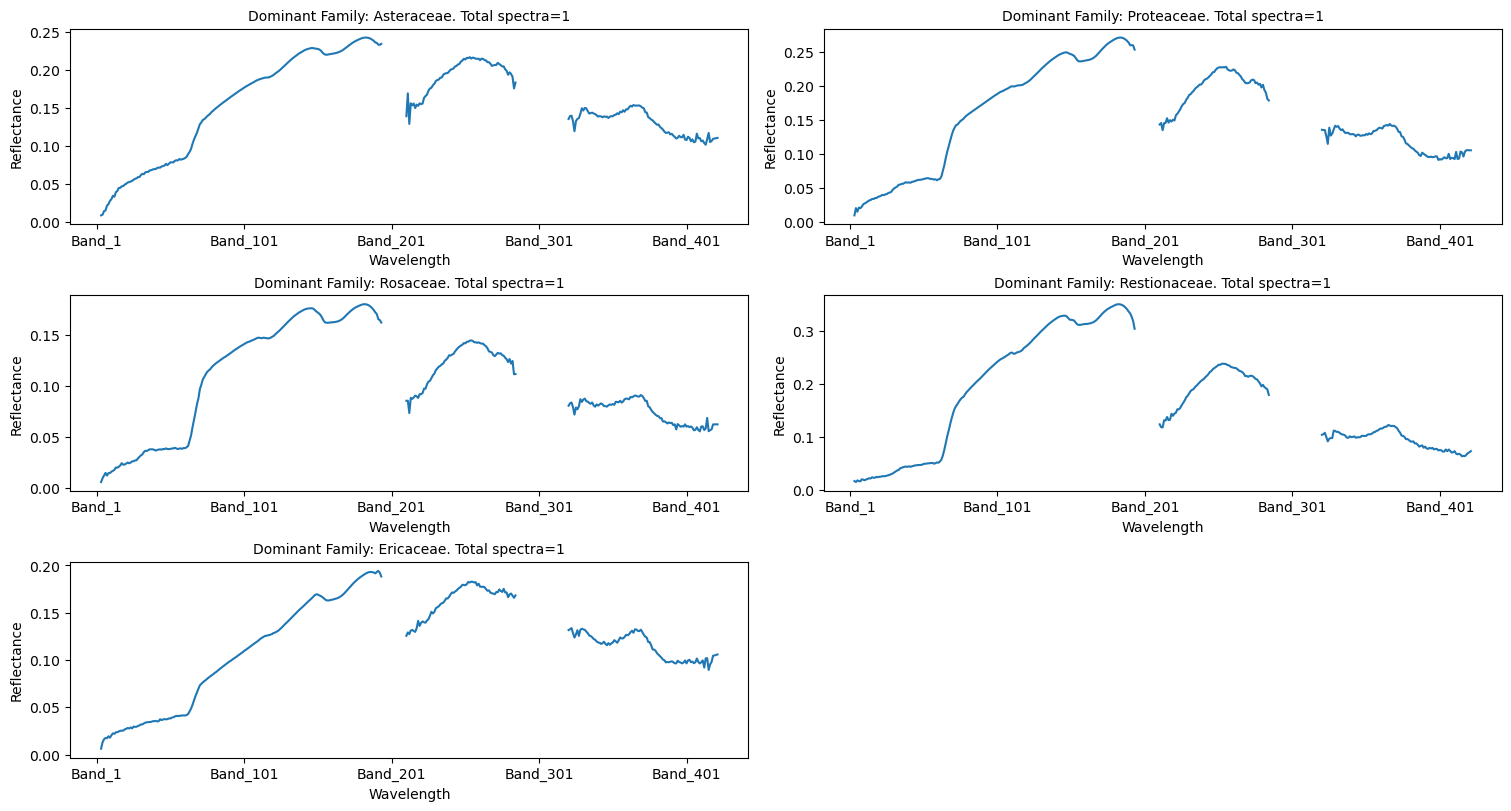

In [11]:
dominant = final_gdf.DominantFamily.unique()
fig = plt.figure(figsize=(15,8), constrained_layout=True)
columns = 2
rows = int(len(dominant)/columns)+1
for i, item in enumerate(dominant):
    # transpose and plot species
    dominant_df = final_gdf[final_gdf.DominantFamily == item]
    dominant_df = dominant_df.filter(like='Band')
    # drop rows with no data values
    dominant_df = dominant_df.replace(-9999, pd.NA).dropna()
    if not dominant_df.empty:
        # setting tails and atmospheric window to nan values
        dominant_df.iloc[:, np.r_[:3,194:210,285:320,422:425]] = np.nan
        dominant_n = len(dominant_df.index)
        ax = fig.add_subplot(rows, columns, i+1)
        dominant_df.T.plot(ax=ax, legend=None, 
                           xlabel="Wavelength", ylabel="Reflectance")
        # ax.set_xticks(a_rfl_xr.wavelength.values.tolist())
        ax.set_title(f"Dominant Family: {item}. Total spectra={len(dominant_df.index)}", 
                     fontsize=10)

plt.show()

## Get AVIRIS-NG spectra for a buffer around the vegetation plot coordinates
We will now retrieve AVIRIS-NG spectra of a 1-pixel buffer (3 x 3 pixels) around the center veg plot coordinates and save it as a CSV file.

![Bioscape](images/3x3plot_bands.PNG)

### First, find the vegetation points that are within the AVIRIS-NG scenes.

In [12]:
def subset_avirisng_buffer(rfl_xr, a_df, b):
    """returns a pandas dataframe with band names and spectral value 
    for a pixel"""
    # Proj class instance with AVN CRS. preserve_units false to ensure 
    # that input coordinates are in meters
    p = Proj(rfl_xr.rio.crs, preserve_units=False)
    # converts the lon,lat veg plot coordinates to the ANG map projection
    x, y = p(a_df.X, a_df.Y)
    # get the spectra of the ANG pixel nearest to the veg plot
    ix = list(a_rfl_xr.x.values).index(a_rfl_xr.sel(x=x, method='nearest').x)
    iy = list(a_rfl_xr.y.values).index(a_rfl_xr.sel(y=y, method='nearest').y)
    rfl_val = a_rfl_xr.isel(y=slice(iy-b, iy+b+1), 
                            x=slice(ix-b, ix+b+1)).values
    # get band names
    band_names = [f'Band_{i}' for i in a_rfl_xr.band.to_numpy()] 
    # convert band and spectra into a dataframe
    rfl_dict = dict(zip(band_names, rfl_val))
    rfl_df = pd.DataFrame([rfl_dict])  
     # add Name, scid columns which we will use to join dataframes later
    rfl_df['Name'] = a_df.Name
    rfl_df['scid'] = a_df.scid
    return rfl_df

### For each vegetation plot, extract and create a csv file with each 3x3 pixel spectral value for each band

In [13]:
# initialize a list for storing aviris dataframe
rfl_list = []
# total number of veg plots to process
sub_n = len(veg_ang_df.scid.unique())
# loop through AVNG files by scid
for i, scid in enumerate(veg_ang_df.scid.unique()):
    # get row(s) that matches scid
    a_temp_df = veg_ang_df[veg_ang_df['scid']==scid]
    # retrieve S3 path of the AVIRIS tile
    a_rfl = get_rfl_path(a_temp_df.fid.values[0], scid)
    print(f'reading scene {i+1} of {sub_n}: {path.basename(a_rfl)}')
    # open the RFL file
    a_rfl_xr = rioxarray.open_rasterio(a_rfl, drivers='ENVI', 
                                       chunks=True, parse_coordinates=True)
    # loop through the veg plots
    for s in a_temp_df.index:
        # get a row
        a_temp = a_temp_df.loc[s]
        # subset around 1 pixel
        rfl_list.append(subset_avirisng_buffer(a_rfl_xr, a_temp, 1))

# concatenate ANG spectra dataframe
avng_rfl_df = pd.concat(rfl_list)
# merge it with the a_sub_gdf dataframe
final_gdf = pd.merge(veg_ang_df, avng_rfl_df, on=["scid", "Name"], how="left")
# write it to CSV
final_gdf.to_csv('ANG_RFL_CapePeninsulaVegBuffer3x3.csv', index=False)

reading scene 1 of 3: ang20231109t133124_003_L2A_OE_main_27577724_RFL_ORT
reading scene 2 of 3: ang20231109t131923_019_L2A_OE_main_27577724_RFL_ORT
reading scene 3 of 3: ang20231109t133124_013_L2A_OE_main_27577724_RFL_ORT


#### Now we'll plot the value of the spectral mean and standard deviation of the 9-pixel block for each vegetation center

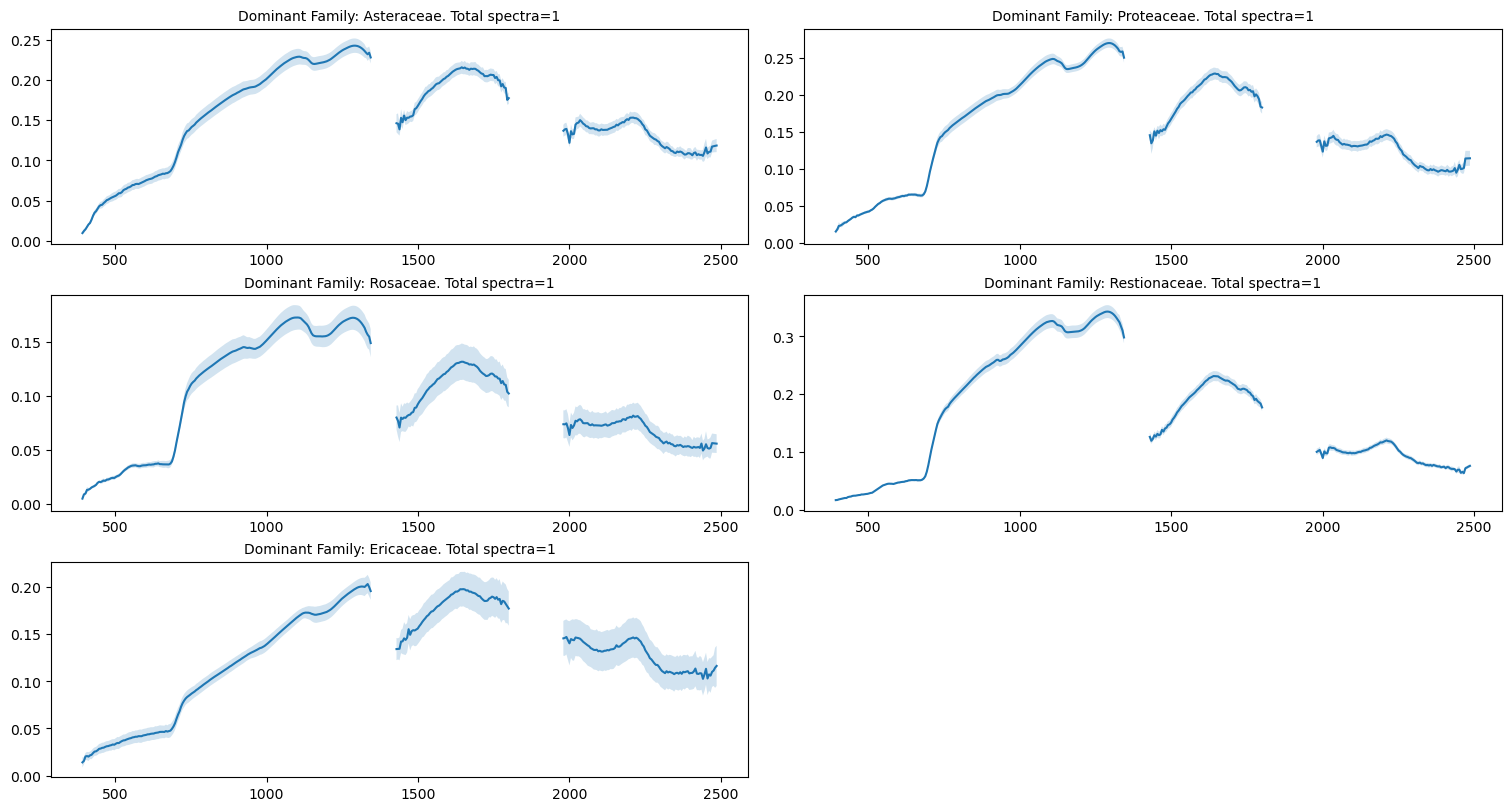

In [14]:
dominant = final_gdf.DominantFamily.unique()
fig = plt.figure(figsize=(15,8), constrained_layout=True)
columns = 2
rows = int(len(dominant)/columns)+1
for i, item in enumerate(dominant):
    # transpose and plot species
    dominant_df = final_gdf[final_gdf.DominantFamily == item]
    dominant_df = dominant_df.filter(like='Band')
    if not dominant_df.empty:
        # setting tails and atmospheric window to nan values
        dominant_df.iloc[:, np.r_[:3,194:210,285:320,422:425]] = np.nan
        mean_df = dominant_df.map(np.mean).T
        std_df = dominant_df.map(np.std).T
        wavelength = a_rfl_xr.wavelength.values.tolist()
        ax = fig.add_subplot(rows, columns, i+1)
        ax.plot(wavelength, mean_df, '-')
        ax.fill_between(wavelength, (mean_df - std_df)[i], (mean_df + std_df)[i], alpha=0.2)
        ax.set_title(f"Dominant Family: {item}. Total spectra={len(dominant_df.index)}", 
                     fontsize=10)

plt.show()